 ## CTA backtesting framework with BTCUSD and bollingerband strategy

 ## import packages

In [1]:
from ast import parse
import os
from re import S
from tkinter import Grid
from tkinter.messagebox import NO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

path = os.getcwd()
print(path)

/Users/abnerteng/GitHub/TMBA-projects/src


In [2]:
symbol = 'BTC/USD'

startTime = '2021-1-1'
endTime = '2022-7-22'
resolution = 60

startTimeStamp = dt.datetime.strptime(startTime, '%Y-%m-%d').timestamp()
endTimeStamp = dt.datetime.strptime(endTime, '%Y-%m-%d').timestamp()
data = []

import tqdm
for i in tqdm.tqdm(range(100)):
    while True:
        if startTimeStamp < endTimeStamp:
            t1 = startTimeStamp
            t2 = startTimeStamp + resolution * 1440

            url = f'https://ftx.com/api//markets/{symbol}/candles?resolution={resolution}&limit=1440&start_time={t1}&end_time={t2}'
            response = requests.get(url)
            if response.status_code == 200:
                result = response.json()['result'][:-1]
                data += result
            else:
                print('error: {}, {} ~ {}'.format(symbol, t1, t2))

            startTimeStamp += resolution * 1440
        else:
            break

data = pd.DataFrame(data)
data.index = pd.to_datetime(data['startTime'])

100%|██████████| 100/100 [05:29<00:00,  3.30s/it] 


 tidy data

In [3]:
data = data[['open', 'high', 'low', 'close', 'volume']]
data.to_csv('/Users/abnerteng/GitHub/TMBA-projects/data/BTCUSD.csv')
pd.read_csv('/Users/abnerteng/GitHub/TMBA-projects/data/BTCUSD.csv', parse_dates = True, index_col = 'startTime')

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28796.0,28836.0,28787.0,28829.5,74365.00665
2020-12-31 16:01:00+00:00,28829.5,28834.0,28728.0,28746.0,326660.45600
2020-12-31 16:02:00+00:00,28746.0,28758.5,28704.0,28708.0,162065.61150
2020-12-31 16:03:00+00:00,28708.0,28738.0,28707.5,28709.0,42449.10475
2020-12-31 16:04:00+00:00,28709.5,28752.5,28693.5,28731.5,75324.97115
...,...,...,...,...,...
2022-07-21 15:55:00+00:00,22651.0,22669.0,22650.0,22663.0,272847.80390
2022-07-21 15:56:00+00:00,22663.0,22666.0,22654.0,22658.0,87820.37250
2022-07-21 15:57:00+00:00,22658.0,22659.0,22641.0,22643.0,15790.17300


 ## Strategy Backtesting
 data resample

In [4]:
rule = '1D'
d1 = data.resample(rule = rule, closed = 'right', label = 'right').first()[['open']]
d2 = data.resample(rule = rule, closed = 'right', label = 'right').max()[['high']]
d3 = data.resample(rule = rule, closed = 'right', label = 'right').min()[['low']]
d4 = data.resample(rule = rule, closed = 'right', label = 'right').last()[['close']]
d5 = data.resample(rule = rule, closed = 'right', label = 'right').sum()[['volume']]

df = pd.concat([d1, d2, d3, d4, d5], axis = 1)
df.iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2021-01-01 00:00:00+00:00,28796.0,29206.5,28322.5,29014.5,4.885853e+07
2021-01-02 00:00:00+00:00,29014.5,29691.5,28700.0,29376.5,1.720617e+08
2021-01-03 00:00:00+00:00,29376.5,33349.5,29023.5,32241.0,2.544067e+08


 ## strategy
 * bollinger band

 setting parameters

In [5]:
fund = 100
money = 100
feeRate = 0.002
length = 20
times_of_std = 2
df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()

for i in range(len(df)):
    df['upper_bound'] = df['ma'] + times_of_std * df['std']
    df['lower_bound'] = df['ma'] - times_of_std * df['std']

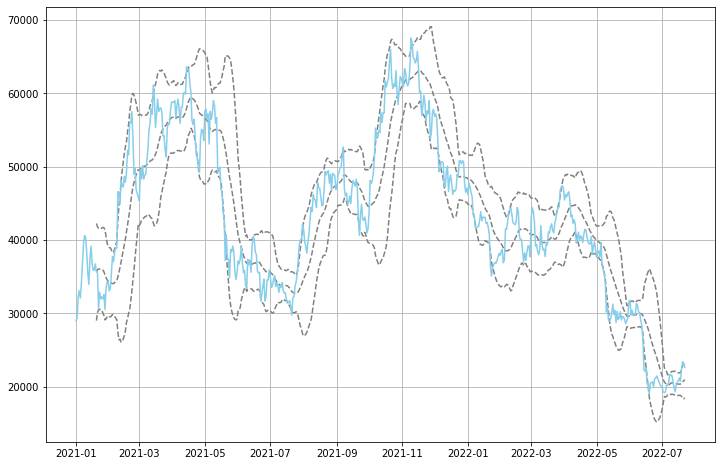

In [6]:
plt.figure(figsize = (12, 8))
plt.plot(df[['ma', 'upper_bound', 'lower_bound']], linestyle =  '--', color = 'gray')
plt.plot(df['close'], color = 'skyblue')
plt.grid(True)

                              profit  profitfee
startTime                                      
2021-01-01 00:00:00+00:00   0.000000   0.000000
2021-01-02 00:00:00+00:00   0.000000   0.000000
2021-01-03 00:00:00+00:00   0.000000   0.000000
2021-01-04 00:00:00+00:00   0.000000   0.000000
2021-01-05 00:00:00+00:00   0.000000   0.000000
...                              ...        ...
2022-07-18 00:00:00+00:00  43.578997  40.732601
2022-07-19 00:00:00+00:00  45.190689  42.344293
2022-07-20 00:00:00+00:00  39.127123  35.848868
2022-07-21 00:00:00+00:00  39.127123  35.848868
2022-07-22 00:00:00+00:00  39.127123  35.848868

[568 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

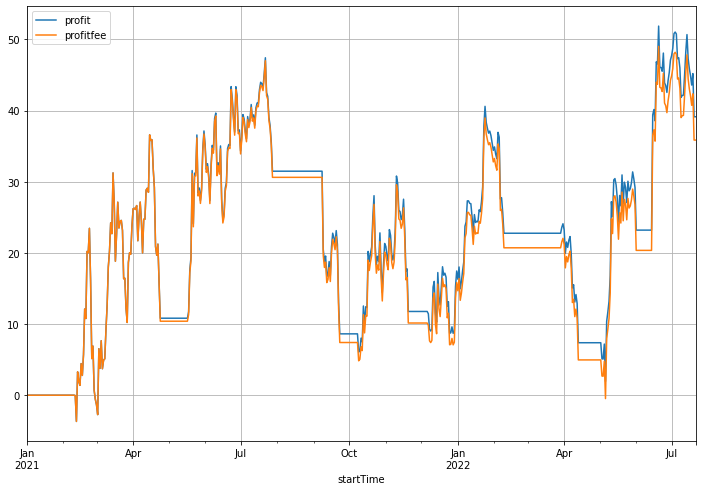

In [7]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df['close'][i-1] > df['lower_bound'][i-1] and df['close'][i] < df['lower_bound'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
        
        if df['close'][i-1] < df['upper_bound'][i-1] and df['close'][i] > df['upper_bound'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)

        if (df['close'][i-1] >= df['lower_bound'][i-1] and df['close'][i] < df['lower_bound'][i]) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)

        if (df['close'][i-1] <= df['upper_bound'][i-1] and df['close'][i] > df['upper_bound'][i]) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

In [8]:
print(buy)
print(short)
print(sell)
print(buytocover)

[40, 250, 280, 452]
[136, 339, 486, 529]
[113, 265, 323, 467]
[208, 404, 516, 565]


In [9]:
equity['drawdown_percent'] = (equity['profitfee'] / equity['profitfee'].cummax()) - 1
equity['drawdown'] = equity['profitfee'] - equity['profitfee'].cummax()

Text(0.5, 1.0, 'Profit & Drawdown')

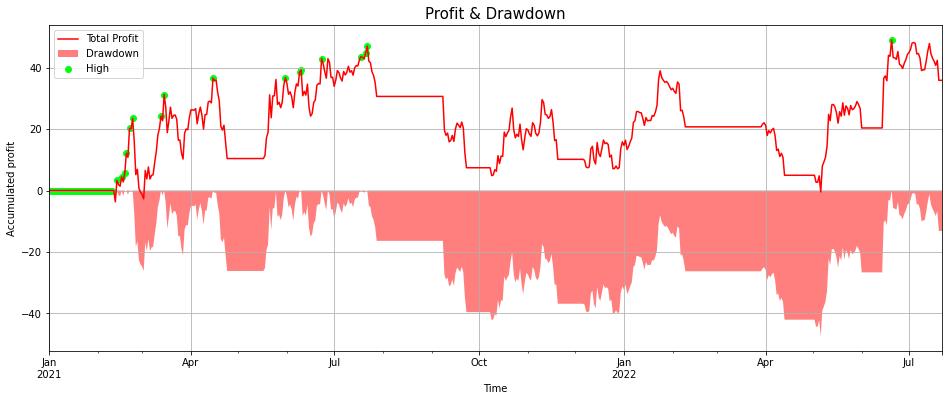

In [10]:
fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize = 15)

Text(0.5, 1.0, 'Price Movement & Trade signal')

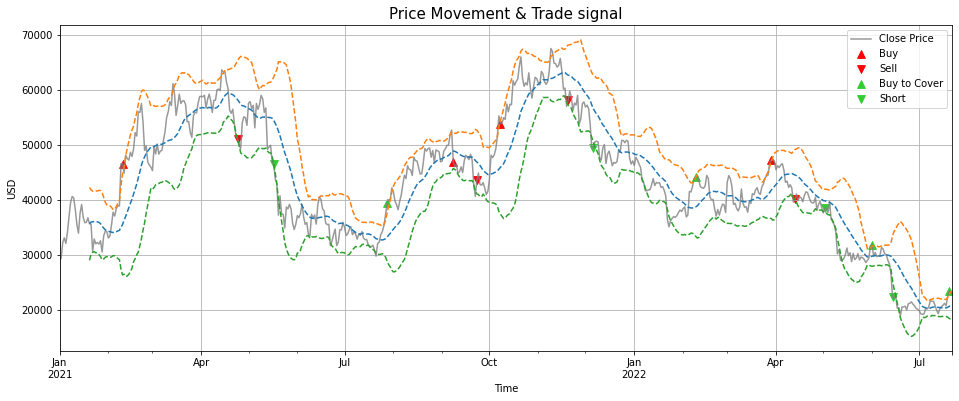

In [12]:
fig, ax = plt.subplots(figsize = (16, 6))
df['close'].plot(label = 'Close Price', ax = ax, color = 'gray', grid = True, alpha = 0.8)
plt.plot(df[['ma', 'upper_bound', 'lower_bound']], linestyle = '--')
plt.grid(True)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy], color = 'red', label = 'Buy', marker = '^', s = 60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell], color = 'red', label = 'Sell', marker = 'v', s = 60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover], color = 'limegreen', label = 'Buy to Cover', marker = '^', s = 60)
plt.scatter(df['close'].iloc[short].index, df['close'].iloc[short], color = 'limegreen', label = 'Short', marker = 'v', s = 60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement & Trade signal', fontsize = 15)

In [13]:
profit = equity['profitfee'].iloc[-1]
returns = (equity['profitfee'][-1] - equity['profitfee'][41])
mdd = abs(equity['drawdown']).max()
calmarRatio = returns / mdd
tradeTimes = len(buy) + len(short)
winRate = len([i for i in profit_fee_list if i > 0]) / len(profit_fee_list)
profitFactor = sum([i for i in profit_fee_list if i > 0]) / abs(sum([i for i in profit_fee_list if i < 0]))
WLRatio = np.mean([i for i in profit_fee_list if i > 0]) / abs(np.mean([i for i in profit_fee_list if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'returns: {np.round(returns,4)}%')
print(f'mdd: {np.round(mdd,4)}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(WLRatio,2)}')

profit: $35.85
returns: 35.9004%
mdd: 47.4691%
calmarRatio: 0.76
tradeTimes: 8
winRate: 30.459999999999997%
profitFactor: 1.08
winLossRatio: 1.09


 ## Strategy optimize

In [14]:
df_insample = df.loc[:'2022-2']
df_outofsample = df.loc['2022-3':]

rule = '1D'
df_open = df['open']

 ## In-sample estimate

In [15]:
optimizationList = []
fund = 100
money = 100
feeRate = 0.02

rule = '1D'

for length in range(10, 110, 10):
    for times_of_std in np.arange(0.5, 3, 0.5):

        times_of_std = np.round(times_of_std, 1)

        print('----------')
        print(f'length: {length}')
        print(f'times_of_std: {times_of_std}')

        d1 = df_insample.resample(rule=rule, closed='right', label='right').first()[['open']]
        d2 = df_insample.resample(rule=rule, closed='right', label='right').max()[['high']]
        d3 = df_insample.resample(rule=rule, closed='right', label='right').min()[['low']]
        d4 = df_insample.resample(rule=rule, closed='right', label='right').last()[['close']]
        d5 = df_insample.resample(rule=rule, closed='right', label='right').sum()[['volume']]
        df = pd.concat([d1,d2,d3,d4,d5], axis=1)

        df['ma'] = df['close'].rolling(window = length, center = False).mean()
        df['std'] = df['close'].rolling(window = length, center = False).std()
        #for i in range(len(df)):
         #   df['upper_bound'][i] = df['ma'][i] + times_of_std * df['std'][i]
          #  df['lower_bound'][i] = df['ma'][i] - times_of_std * df['std'][i]

        B_or_S = None
        buy = []
        sell = []
        short = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]

        for i in range(len(df)):

            if i == len(df) - 1:
                break

            if B_or_S == None:
                profit_list.append(0)
                profit_fee_list.append(0)

                if df['close'][i-1] > (df['ma'][i-1] - times_of_std * df['std'][i-1]) and df['close'][i] < (df['ma'][i] - times_of_std * df['std'][i]):
                    executeSize = money / df['open'][i+1]
                    B_or_S = 'S'
                    t = i + 1
                    short.append(t)
        
                if df['close'][i-1] < (df['ma'][i-1] + times_of_std * df['std'][i-1]) and df['close'][i] > (df['ma'][i] + times_of_std * df['std'][i]):
                    executeSize = money / df['open'][i+1]
                    B_or_S = 'B'
                    t = i + 1
                    buy.append(t)

            elif B_or_S == 'B':
                profit = executeSize * (df['open'][i+1] - df['open'][i])
                profit_list.append(profit)

                if (df['close'][i-1] >= df['ma'][i-1] - times_of_std * df['std'][i-1] and df['close'][i] < df['ma'][i] - times_of_std * df['std'][i]) or (i == len(df) - 2):
                    pl_round = executeSize * (df['open'][i+1] - df['open'][t])
                    profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    B_or_S = None
        
                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)

            elif B_or_S == 'S':
                profit = executeSize * (df['open'][i] - df['open'][i+1])
                profit_list.append(profit)

                if (df['close'][i-1] <= df['ma'][i-1] + times_of_std * df['std'][i-1] and df['close'][i] > df['ma'][i] + times_of_std * df['std'][i]) or (i == len(df) - 2):
                    pl_round = executeSize * (df['open'][t] - df['open'][i+1])
                    profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
                    profit_fee_list.append(profit_fee)
                    buytocover.append(i+1)
                    B_or_S = None
        
                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)

        equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
        equity['drawdown_percent'] = (equity['profitfee'] / equity['profitfee'].cummax()) - 1
        equity['drawdown'] = equity['profitfee'] - equity['profitfee'].cummax()
        returns = (equity['profitfee'][-1] - equity['profitfee'][41])
        mdd = abs(equity['drawdown']).max()
        calmarRatio = returns / mdd

        optimizationList.append([length, times_of_std, returns, calmarRatio])

----------
length: 10
times_of_std: 0.5
----------
length: 10
times_of_std: 1.0
----------
length: 10
times_of_std: 1.5
----------
length: 10
times_of_std: 2.0
----------
length: 10
times_of_std: 2.5
----------
length: 20
times_of_std: 0.5
----------
length: 20
times_of_std: 1.0
----------
length: 20
times_of_std: 1.5
----------
length: 20
times_of_std: 2.0
----------
length: 20
times_of_std: 2.5
----------
length: 30
times_of_std: 0.5
----------
length: 30
times_of_std: 1.0
----------
length: 30
times_of_std: 1.5
----------
length: 30
times_of_std: 2.0
----------
length: 30
times_of_std: 2.5
----------
length: 40
times_of_std: 0.5
----------
length: 40
times_of_std: 1.0
----------
length: 40
times_of_std: 1.5
----------
length: 40
times_of_std: 2.0
----------
length: 40
times_of_std: 2.5
----------
length: 50
times_of_std: 0.5
----------
length: 50
times_of_std: 1.0
----------
length: 50
times_of_std: 1.5
----------
length: 50
times_of_std: 2.0
----------
length: 50
times_of_std: 2.5


In [16]:
optResult = pd.DataFrame(optimizationList, columns = ['length', 'times_of_std', 'returns', 'calmarRatio'])
optResult

,length,times_of_std,returns,calmarRatio
0,10,0.5,-122.034079,-0.788618
1,10,1.0,-123.580781,-0.700554
2,10,1.5,-28.910752,-0.416890
3,10,2.0,-32.206114,-0.467392
4,10,2.5,-58.666002,-0.981839
5,20,0.5,-115.899964,-0.816861
6,20,1.0,-116.491811,-0.810928
7,20,1.5,-0.744215,-0.011887
8,20,2.0,2.355337,0.046420
9,20,2.5,-9.247821,-0.127256


[Text(0.5, 1.0, 'Return')]

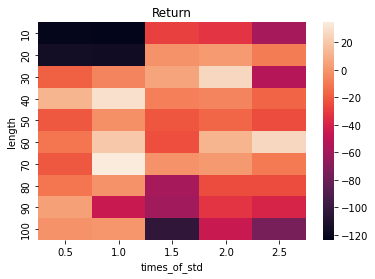

In [17]:
pic = optResult.pivot('length', 'times_of_std', 'returns')
sns.heatmap(data = pic).set(title='Return')

[Text(0.5, 1.0, 'Calmar Ratio')]

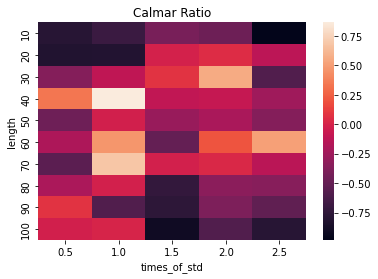

In [18]:
pic = optResult.pivot('length', 'times_of_std', 'calmarRatio')
sns.heatmap(data = pic).set(title='Calmar Ratio')

 ## Out of sample

In [34]:
fund = 100
money = 100
feeRate = 0.02
length = 40
times_of_std = 1
rule = '1D'

d1 = df_outofsample.resample(rule=rule, closed='right', label='right').first()[['open']]
d2 = df_outofsample.resample(rule=rule, closed='right', label='right').max()[['high']]
d3 = df_outofsample.resample(rule=rule, closed='right', label='right').min()[['low']]
d4 = df_outofsample.resample(rule=rule, closed='right', label='right').last()[['close']]
d5 = df_outofsample.resample(rule=rule, closed='right', label='right').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)

df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
##for i in range(len(df)):
    ##df['upper_bound'][i] = df['ma'][i] + times_of_std * df['std'][i]
    ##df['lower_bound'][i] = df['ma'][i] - times_of_std * df['std'][i]

In [43]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df['close'][i-1] > (df['ma'][i-1] - times_of_std * df['std'][i-1]) and df['close'][i] < (df['ma'][i] - times_of_std * df['std'][i]):
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)

        if df['close'][i-1] < (df['ma'][i-1] + times_of_std * df['std'][i-1]) and df['close'][i] > (df['ma'][i] + times_of_std * df['std'][i]):
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)

        if (df['close'][i-1] >= df['ma'][i-1] - times_of_std * df['std'][i-1] and df['close'][i] < df['ma'][i] - times_of_std * df['std'][i]) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)

        if (df['close'][i-1] <= df['ma'][i-1] + times_of_std * df['std'][i-1] and df['close'][i] > df['ma'][i] + times_of_std * df['std'][i]) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
equity['drawdown_percent'] = (equity['profitfee'] / equity['profitfee'].cummax()) - 1
equity['drawdown'] = equity['profitfee'] - equity['profitfee'].cummax()

profit = equity['profitfee'].iloc[-1]
returns = (equity['profitfee'][-1] - equity['profitfee'][41])
mdd = abs(equity['drawdown']).max()
calmarRatio = returns / mdd
tradeTimes = len(buy) + len(short)
winRate = len([i for i in profit_fee_list if i > 0]) / len(profit_fee_list)
profitFactor = sum([i for i in profit_fee_list if i > 0]) / abs(sum([i for i in profit_fee_list if i < 0]))
WLRatio = np.mean([i for i in profit_fee_list if i > 0]) / abs(np.mean([i for i in profit_fee_list if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'returns: {np.round(returns,4)}%')
print(f'mdd: {np.round(mdd,4)}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(WLRatio,2)}')

profit: $36.6
returns: 36.5962%
mdd: 15.5439%
calmarRatio: 2.35
tradeTimes: 1
winRate: 34.03%
profitFactor: 1.45
winLossRatio: 1.34


Text(0.5, 1.0, 'Profit & Drawdown')

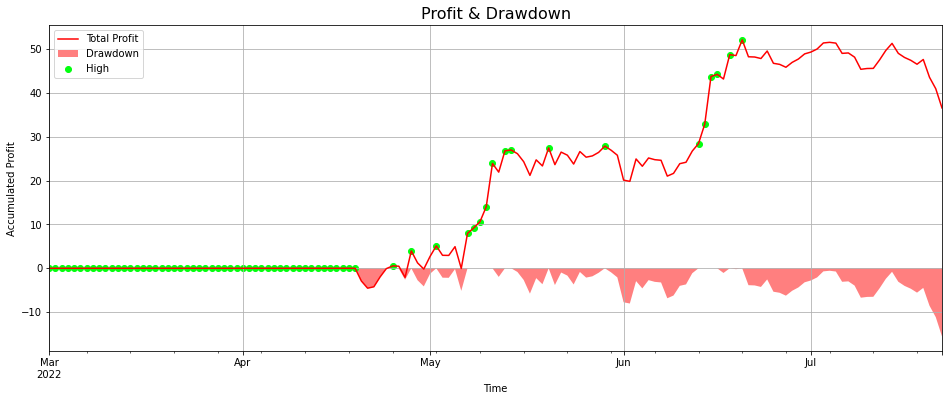

In [44]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16)